In [1]:
import os
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Set up file read/folder structure
os.chdir("C:\\Users\\erroden\\Desktop\\Capstone")

# Local Sources
# Initial focus will be on the airline data set but others may be stitched on to enrich the data
airline = pd.read_csv("data\\airline_2.csv")
airline.drop(airline.columns[0], axis=1, inplace=True) # drop extra index column

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# generate tokens
tokenizer = RegexpTokenizer(r'\w+')
airline['tokens'] = airline.content.apply(tokenizer.tokenize)

airline['tokens'].head()

0    [We, were, traveling, from, Paris, to, Skopje,...
1    [Ljubljana, to, Munich, Adria, s, checkin, sys...
2    [A, very, unpleasant, experience, for, my, fam...
3    [Frankfurt, to, Ljubljana, Flight, was, very, ...
4    [Ljubljana, to, Frankfurt, Flight, delayed, fo...
Name: tokens, dtype: object

In [4]:
# load stop words
stops = set(stopwords.words('english'))

# remove stops and make all same case
airline['clean'] = airline['tokens'].apply(lambda x: [word.lower() for word in x if word not in stops])

# remove punctuation and numbers
airline['clean'] = airline['clean'].apply(lambda x: [word for word in x if re.search('^[a-zA-Z]+', word)])

# Lemmatizer 
lemmatizer = nltk.WordNetLemmatizer()

# lemmatize
airline['clean'] = airline['clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

airline['ready'] =  airline['clean'].apply(lambda x: ' '.join(x))

airline['ready'].head()

0    we traveling paris skopje may via ljubljana ou...
1    ljubljana munich adria checkin system obviousl...
2    a unpleasant experience family we bought two r...
3    frankfurt ljubljana flight comfortable profess...
4    ljubljana frankfurt flight delayed hour due te...
Name: ready, dtype: object

In [5]:
# make and fit the vectorizor
vectorizer = CountVectorizer(max_df=0.95, min_df=.05, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')

data_vectorized = vectorizer.fit_transform(airline['ready'])

In [6]:
# check sparsity

# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  11.649836431587932 %


In [13]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\externals\joblib\pool.py:438: UserWarning: Failed to clean temporary folder: C:\Users\erroden\AppData\Local\Temp\joblib_memmaping_pool_4844_2473663279960
  warnings.warn("Failed to clean temporary folder: %s" % folder_path)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [14]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -9968109.201407196
Perplexity:  123.3367660426307
{'evaluate_every': -1, 'n_jobs': -1, 'learning_offset': 10.0, 'n_topics': 20, 'learning_decay': 0.7, 'n_components': 10, 'doc_topic_prior': None, 'topic_word_prior': None, 'random_state': 100, 'max_doc_update_iter': 100, 'total_samples': 1000000.0, 'batch_size': 128, 'perp_tol': 0.1, 'learning_method': 'online', 'verbose': 0, 'mean_change_tol': 0.001, 'max_iter': 10}


In [15]:
# grid search to tune

# Define Search Param
search_params = {'n_components': [10, 20, 50, 100], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\decomp

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 20, 50, 100], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_components': 10, 'learning_decay': 0.7}
Best Log Likelihood Score:  -3258862.56993802
Model Perplexity:  111.42797530966104


In [88]:
# save the best model for quick loading in the future
from sklearn.externals import joblib
joblib.dump(best_lda_model, 'lda.pkl') 

['lda.pkl']

In [10]:
# load best lda model
from sklearn.externals import joblib
best_lda_model = joblib.load('lda.pkl') 
print(best_lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


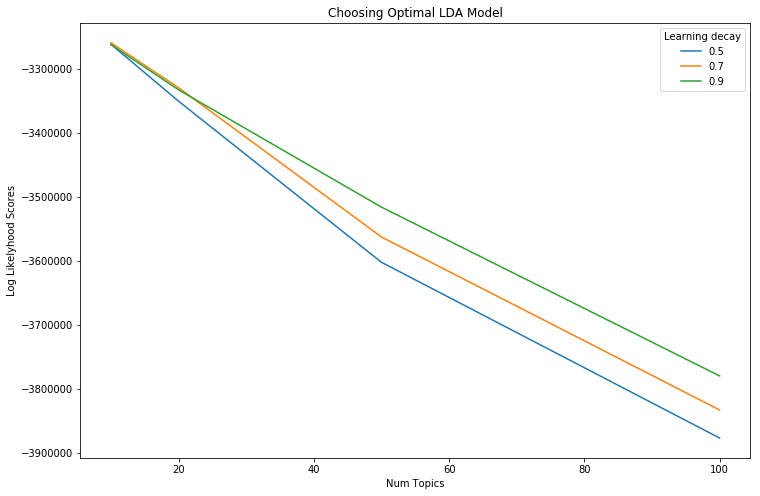

In [17]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 20, 50, 100]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [11]:
data = airline['ready']

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.71,0,0.05,0,0,0,0.14,0,0,0.08,0
Doc1,0,0,0.27,0,0,0,0.3,0,0.33,0.07,8
Doc2,0.73,0,0,0,0.08,0,0,0,0,0.17,0
Doc3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.9,0.01,8
Doc4,0.73,0,0,0.06,0.1,0,0,0,0,0.08,0
Doc5,0.16,0.34,0,0.03,0,0.06,0.16,0.15,0,0.1,1
Doc6,0.18,0.01,0.01,0.41,0.01,0.01,0.01,0.38,0.01,0.01,3
Doc7,0.3,0.01,0.34,0.01,0.19,0.01,0.01,0.01,0.01,0.13,2
Doc8,0.39,0,0,0,0,0,0.59,0,0,0,6
Doc9,0.08,0,0.07,0.21,0,0.06,0,0.3,0,0.27,7


In [31]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,22259
1,0,18943
2,9,10051
3,2,9794
4,8,8145
5,1,3979
6,6,3003
7,5,1722
8,3,1212
9,4,694


In [12]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')

In [13]:
pyLDAvis.show(panel)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [20/Aug/2018 22:10:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Aug/2018 22:10:14] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [20/Aug/2018 22:10:14] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Aug/2018 22:10:15] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Aug/2018 22:10:15] code 404, message Not Found
127.0.0.1 - - [20/Aug/2018 22:10:15] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


In [14]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,able,air,aircraft,airline,airport,airway,arrival,arrived,asked,attendant,...,use,used,wait,waiting,water,way,went,work,worst,year
Topic0,1461.708046,3577.391608,46.532806,13885.075999,12839.193352,2.244029,0.100445,2536.552247,0.100038,1970.094895,...,1997.899474,388.183789,3875.242750,3923.731214,0.538030,2973.237218,1743.533006,1373.267578,2243.858154,0.123635
Topic1,151.619428,225.214271,25.380313,359.580217,199.851525,0.100035,0.100019,0.100018,0.100034,0.100025,...,1058.053699,720.425265,0.101594,0.100019,0.100009,432.876377,0.100027,0.100034,0.100312,0.100019
Topic2,1586.056033,1984.178568,0.100665,1654.706499,10448.339795,322.156634,1.852011,4159.207002,2914.079177,3614.995866,...,1858.357815,621.928082,2858.653812,2328.346489,0.100018,3133.551461,3674.666604,907.425461,0.105416,0.100019
Topic3,9.197716,408.505818,79.703538,612.463943,0.100025,104.730231,0.100016,0.100022,1243.651636,0.100029,...,180.765320,226.336322,0.100019,0.100017,7285.598648,642.664685,0.100026,0.100027,0.100018,0.100016
Topic4,0.130979,49.335636,3021.277666,0.114942,70.284663,0.100029,5720.577941,5529.382882,320.778054,0.100023,...,0.100024,0.100028,0.100028,0.100029,0.100015,13.117509,0.100027,0.100023,0.100017,0.100062


In [17]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,flight,hour,delayed,airline,delay,time,day,airport,plane,told,cancelled,service,hotel,fly,customer
Topic 1,class,business,lounge,economy,seat,service,food,good,passenger,cabin,quality,new,really,comfortable,better
Topic 2,check,flight,luggage,boarding,airport,time,plane,staff,line,people,online,passenger,gate,got,hour
Topic 3,drink,meal,water,snack,free,ife,served,offered,flight,small,food,hour,available,plane,offer
Topic 4,late,minute,gate,departure,time,arrival,arrived,boarding,left,passenger,ground,terminal,aircraft,baggage,board
Topic 5,seat,leg,room,row,plane,space,uncomfortable,return,flight,economy,paid,booked,passenger,little,available
Topic 6,bag,pay,airline,customer,ticket,said,extra,service,baggage,cost,asked,rude,paid,told,money
Topic 7,flight,good,food,seat,service,entertainment,great,excellent,time,comfortable,meal,inflight,attendant,staff,movie
Topic 8,crew,cabin,flight,friendly,good,time,aircraft,pleasant,clean,return,staff,comfortable,check,efficient,food
Topic 9,airline,flight,service,time,air,year,plane,fly,staff,flying,really,flew,experience,airway,old


In [18]:
# function to take in a new review and generate topics for it
def predict_topic(text):

    # generate tokens
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = pd.DataFrame(text)[0].apply(tokenizer.tokenize)

    # load stop words
    stops = set(stopwords.words('english'))

    # remove stops and make all same case
    text_clean = tokens.apply(lambda x: [word.lower() for word in x if word not in stops])

    # remove punctuation and numbers
    text_clean = text_clean.apply(lambda x: [word for word in x if re.search('^[a-zA-Z]+', word)])

    # Lemmatizer 
    lemmatizer = nltk.WordNetLemmatizer()

    # lemmatize
    text_clean = text_clean.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    text_ready =  text_clean.apply(lambda x: ' '.join(x))

    # Step 3: Vectorize transform
    mytext = vectorizer.transform(text_ready)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [19]:
# Predict the topic
mytext = ["my flight was aweful. we were delayed for a long time so I missed my connection and was not offered a replacement ticket."]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['flight', 'hour', 'delayed', 'airline', 'delay', 'time', 'day', 'airport', 'plane', 'told', 'cancelled', 'service', 'hotel', 'fly', 'customer']


In [20]:
# Construct the k-means clusters
from sklearn.cluster import MiniBatchKMeans
clusters = MiniBatchKMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.57  0.13  0.25  0.12  0.1   0.12  0.16  0.6   0.24  0.33]
 [ 0.76 -0.07  0.04 -0.05  0.03 -0.03  0.05 -0.62 -0.11 -0.09]]
Perc of Variance Explained: 
 [0.04 0.34]


Text(0.5,1,'Segregation of Topic Clusters')

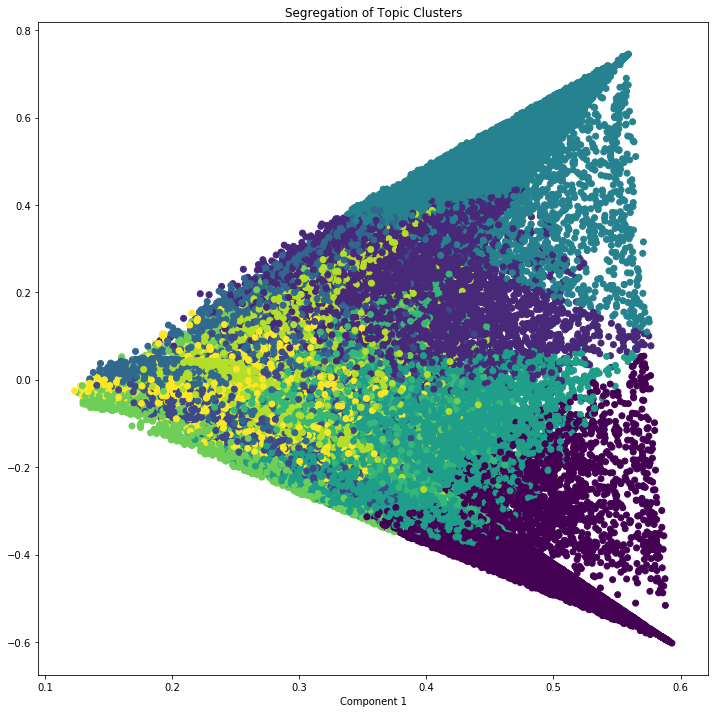

In [21]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [22]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [23]:
# Get similar documents
mytext = ["my flight was aweful. we were delayed for a long time so I missed my connection and was not offered a replacement ticket."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = airline['ready'].as_matrix(), top_n=5, verbose=True)
print('\n', docs)

Topic KeyWords:  ['flight', 'hour', 'delayed', 'airline', 'delay', 'time', 'day', 'airport', 'plane', 'told', 'cancelled', 'service', 'hotel', 'fly', 'customer']
Topic Prob Scores of text:  [[0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 ['ually fly exeter dublin i think i collapse spot flight leave time delay min appear minimum even longer uncommon the cost flight become reasonable punctuality woeful'
 'aug hyderabad mumbai ai964 scheduled time flight started total delay hr without information no proper communication supervisor available update no passenger got update proper management please improve service'
 'booked bahamsair flight form george town nassau flight failed turn use another carrier had kindness staff nassau would missed flight uk we

In [30]:
airline['topic_cluster'] = ['Topic ' + str(cluster) for cluster in clusters]
airline['topic_cluster'].head()

0    Topic 4
1    Topic 3
2    Topic 4
3    Topic 2
4    Topic 4
Name: topic_cluster, dtype: object

In [42]:
sep = ', '
df_topic_keywords['key_words'] = df_topic_keywords.apply(sep.join, axis=1)

In [43]:
df_topic_keywords.loc['Topic 0', 'key_words']

'flight, hour, delayed, airline, delay, time, day, airport, plane, told, cancelled, service, hotel, fly, customer'

In [44]:
airline2 = pd.merge(airline, df_topic_keywords, how='left', left_on='topic_cluster', right_index=True)

,aircraft,cabin_flown,cabin_staff_rating,date,food_beverages_rating,ground_service_rating,inflight_entertainment_rating,recommended,route,seat_comfort_rating,...,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,key_words
0,NaN,Economy Class,3.0,May 2018,NaN,3.0,NaN,0,Paris to Skopje via Ljubljana,3.0,...,arrived,boarding,left,passenger,ground,terminal,aircraft,baggage,board,"late, minute, gate, departure, time, arrival, ..."
1,NaN,Economy Class,2.0,June 2018,2.0,2.0,NaN,0,Ljubljana to Munich,1.0,...,served,offered,flight,small,food,hour,available,plane,offer,"drink, meal, water, snack, free, ife, served, ..."
2,A319,Economy Class,3.0,June 2018,NaN,1.0,NaN,0,Ljubljana to Prague,3.0,...,arrived,boarding,left,passenger,ground,terminal,aircraft,baggage,board,"late, minute, gate, departure, time, arrival, ..."
3,NaN,Economy Class,5.0,April 2018,5.0,5.0,NaN,1,Frankfurt to Ljubljana,5.0,...,plane,staff,line,people,online,passenger,gate,got,hour,"check, flight, luggage, boarding, airport, tim..."
4,NaN,Economy Class,1.0,March 2018,1.0,1.0,1.0,0,Ljubljana to Frankfurt,2.0,...,arrived,boarding,left,passenger,ground,terminal,aircraft,baggage,board,"late, minute, gate, departure, time, arrival, ..."


In [47]:
# Set up file read/folder structure
import os
os.chdir("C:\\Users\\erroden\\Desktop\\Capstone\\")

airline2.to_csv('data\\airline_with_topic.csv', index=False)